In [8]:
%matplotlib inline
import numpy as np
import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing
from scipy.stats import norm  # ガウス分布（正規分布）のオブジェクトをインポート

class Particle:
    def __init__(self,p,w):
        self.pose = np.array(p)
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)
    
def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks]
    ys = [ e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

def relative_landmark_pos(pose,landmark):
    x,y,theta = pose
    lx,ly = landmark
    distance = math.sqrt((x -lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - theta
    
    return (distance, direction,lx,ly) # 実際の位置も一緒に返す

def draw_observation(pose,  measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink")
    
def draw_observations(pose,  measurements):
    for m in measurements:
        draw_observation(pose, m)

def observation(pose, landmark):
    actual_distance,actual_direction,lx,ly = relative_landmark_pos(pose,landmark)
    # 方向の制限（cosの値が正）
    if (math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance,actual_distance*0.1)  
    measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi)  
    
    return (measured_distance, measured_direction,lx,ly)

def observations(pose,landmarks):
    return filter(lambda x: x != None, [ observation(pose,e) for e in landmarks])


        

def f(x_old,u):
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw,act_fw/10)
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    act_rot = random.gauss(act_rot,act_rot/10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x,pos_y,pos_theta])

### 描画関数は少し変更を ###
def draw(pose,particles,ti):    
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles]  #重みで長さを変えるようにしましょう
    vys = [math.sin(e.pose[2])*e.weight for e in particles]  #重みで長さを変えるようにしましょう
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")
    
    plt.text(-0.3,1.3,str(ti) + "times")
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

## パーティクルの姿勢と観測結果を比較する関数 ###

def likelihood(pose, measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    
    # パーティクルの姿勢から観測されるはずのランドマークの距離と向き
    rel_distance, rel_direction, tmp_x,tmp_y = relative_landmark_pos(pose,(lx,ly))

    # 誤差をガウスで評価
    return norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance / 10.0)  \
             * norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0/180.0 * math.pi)
    
### パーティクル群の重みを変更する関数 ###
def change_weights(particles, measurement):
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    # 重みの合計を1に保つ
    ws = [ p.weight for p in particles ]
    s = sum(ws)
    for p in particles: p.weight = p.weight / s
        
def resampling(particles) :
    accum = []
    sm = 0.0
    for p in particles:
        accum.append(p.weight + sm)
        sm += p.weight
    pointer = random.uniform(0.0,1.0/len(particles))

    new_particles = []
    particles_num = len(particles)

    while pointer < 1.0:
        if accum[0] >= pointer:
            new_particles.append(
                Particle(copy.deepcopy(particles[0].pose),1.0/particles_num)
            )
            pointer += 1.0/particles_num
        else:
            accum.pop(0)
            particles.pop(0)
    return new_particles
    

C:\Users\Takayuki\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


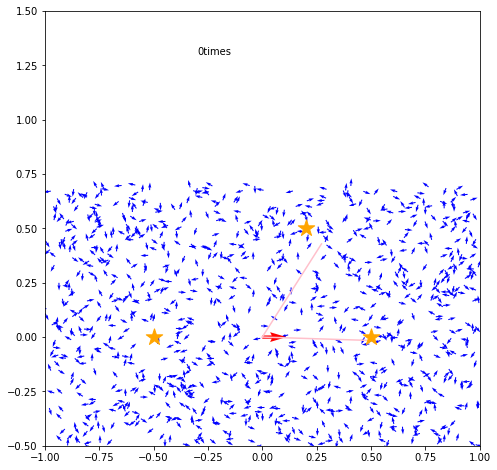

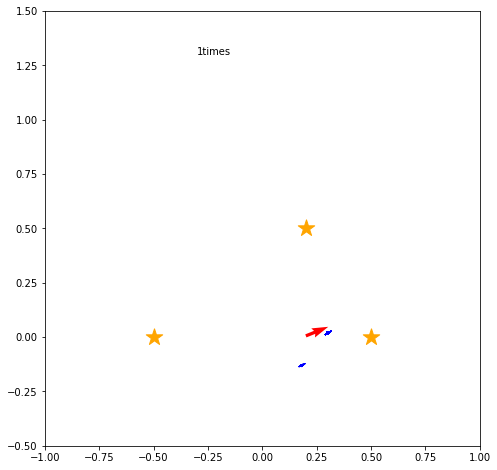

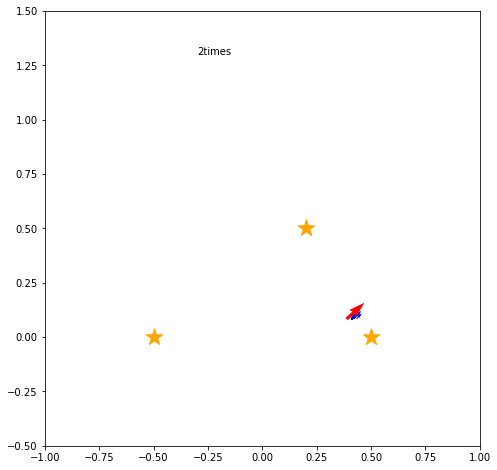

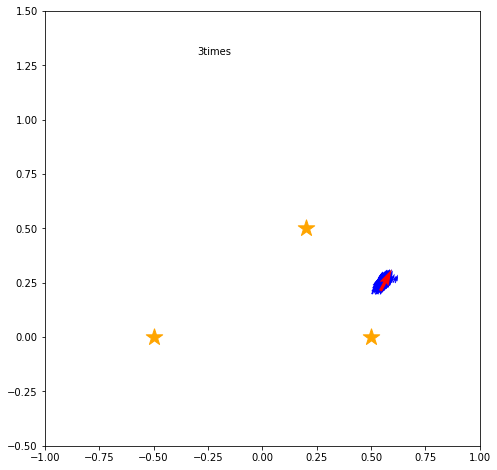

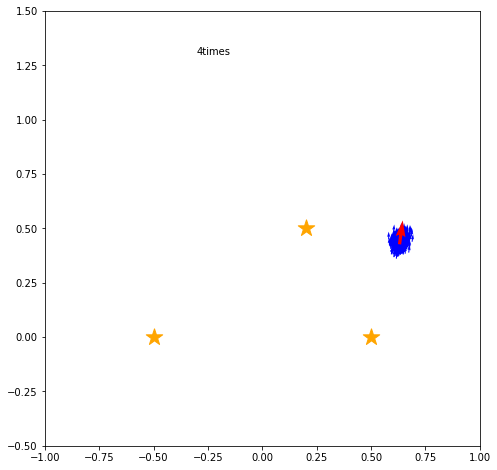

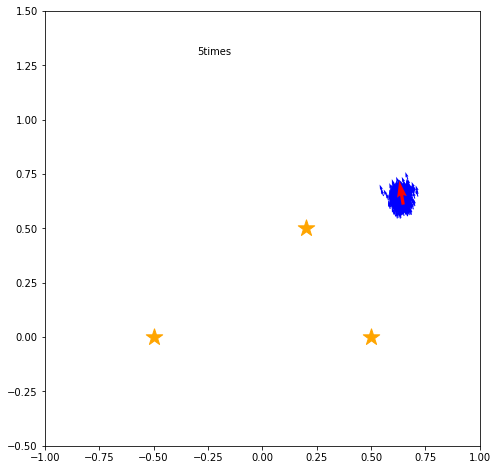

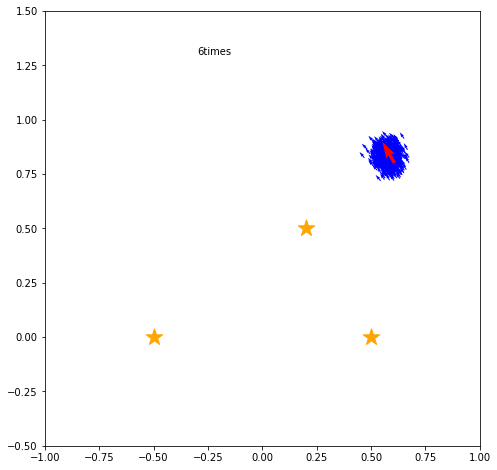

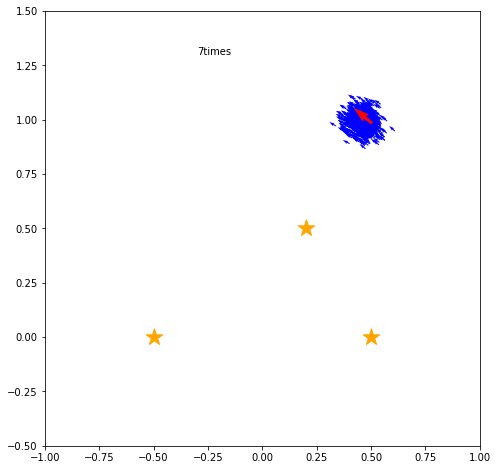

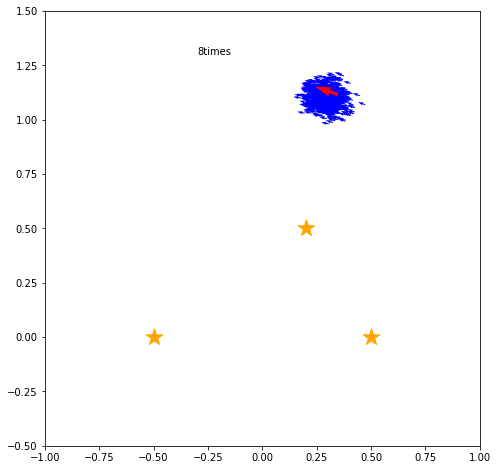

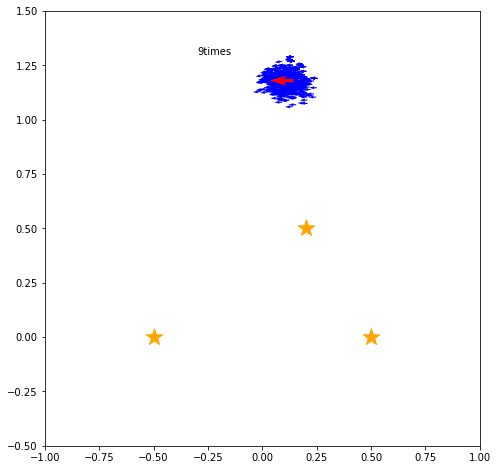

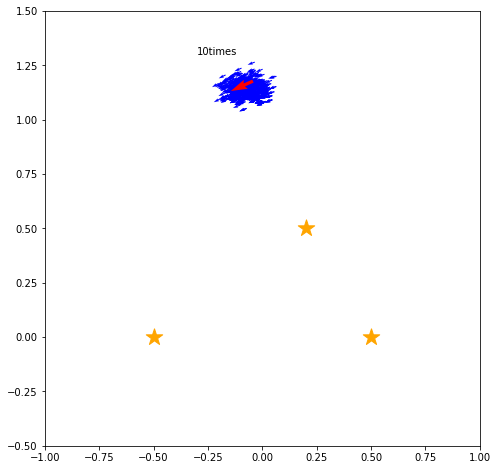

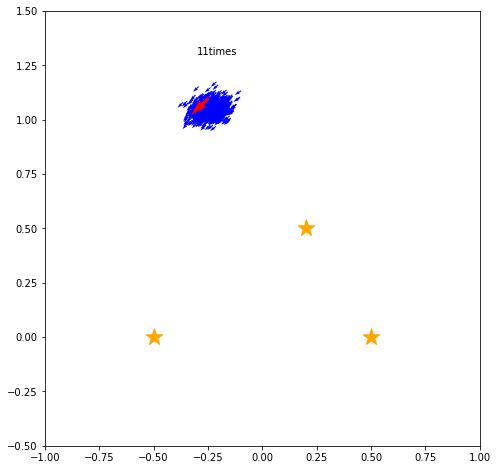

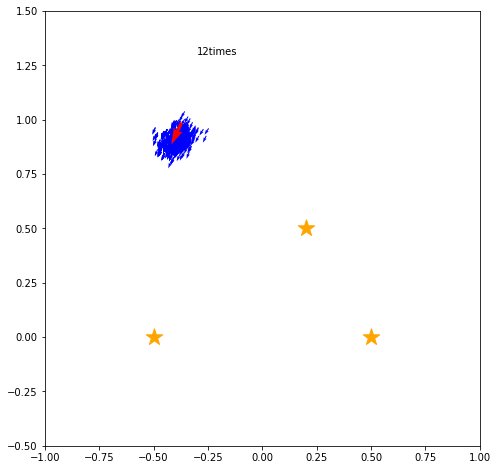

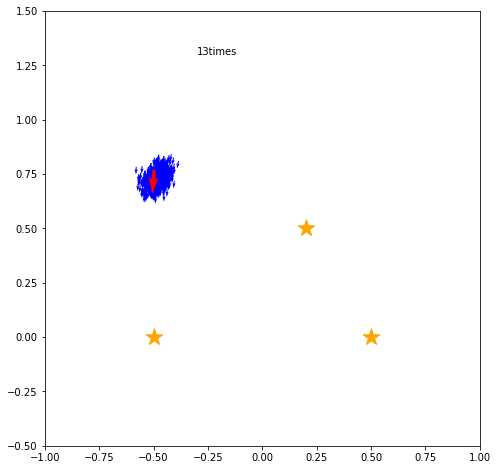

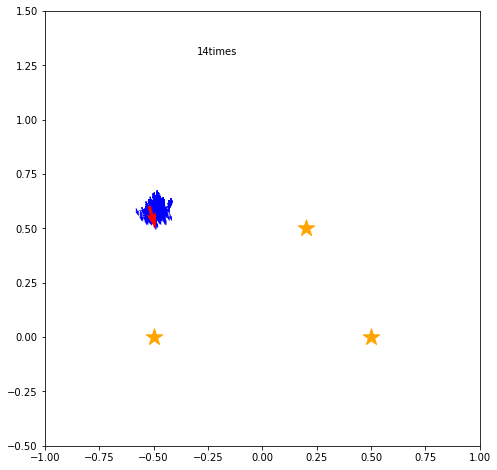

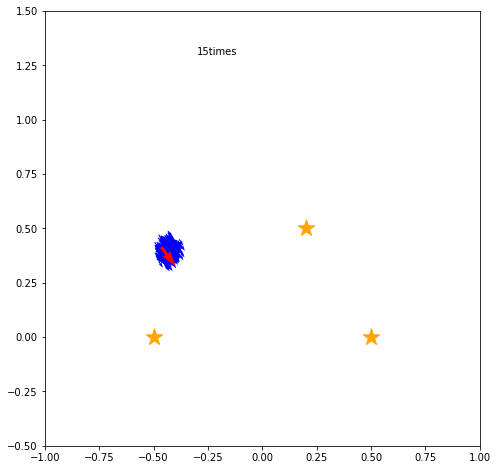

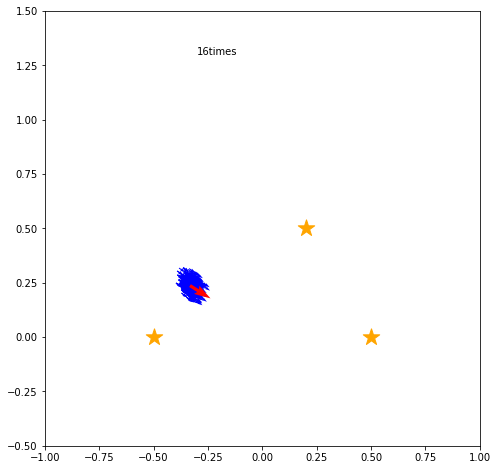

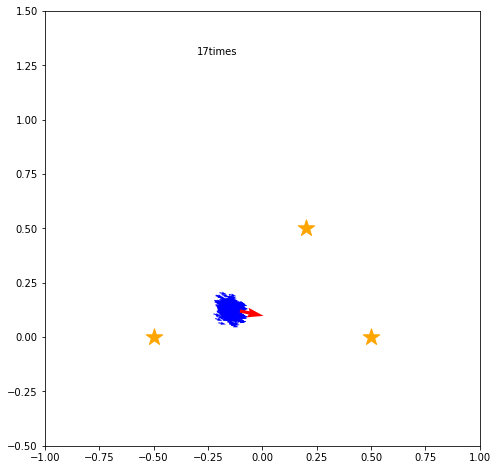

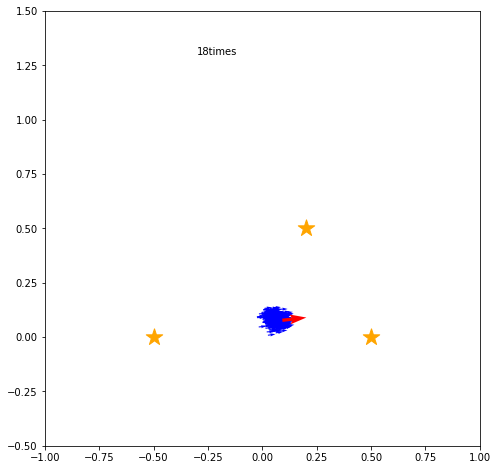

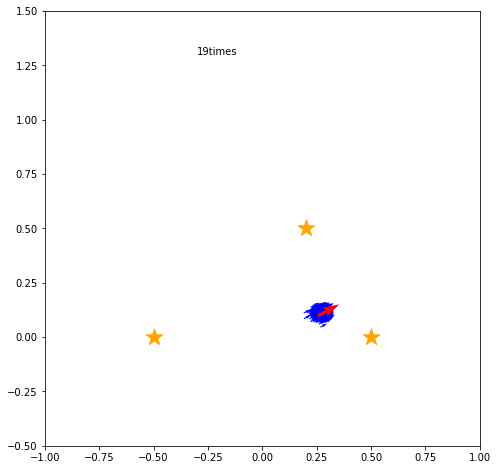

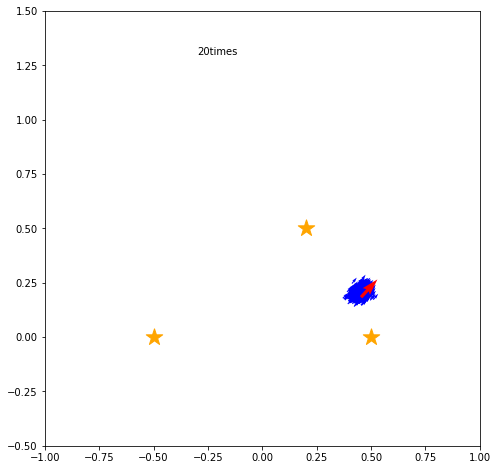

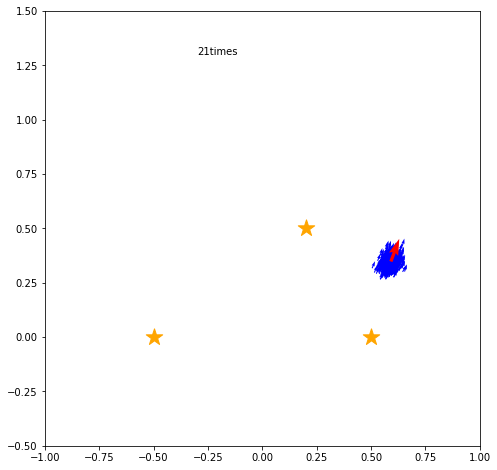

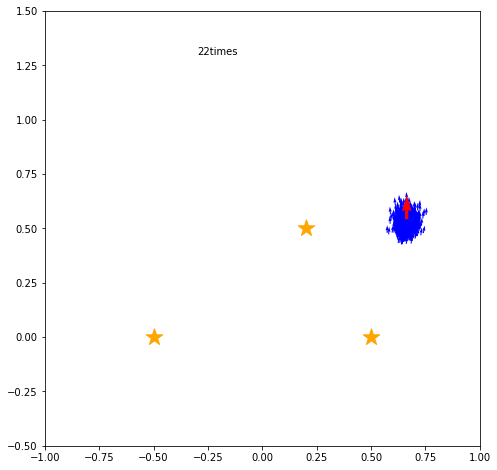

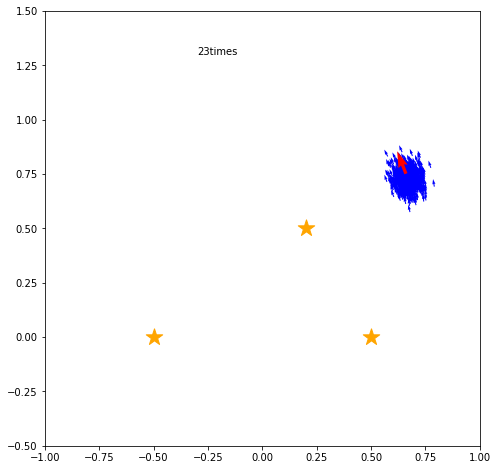

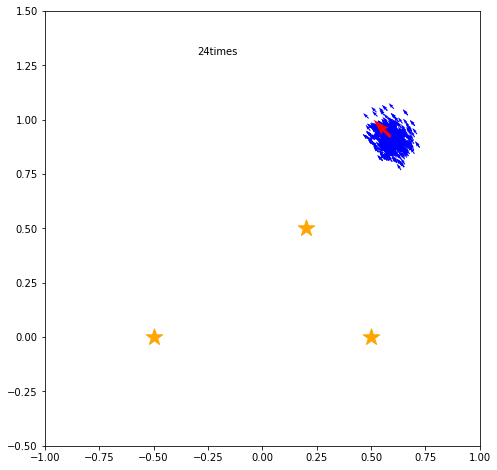

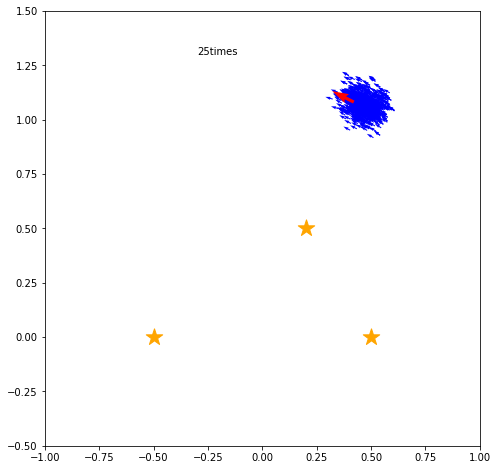

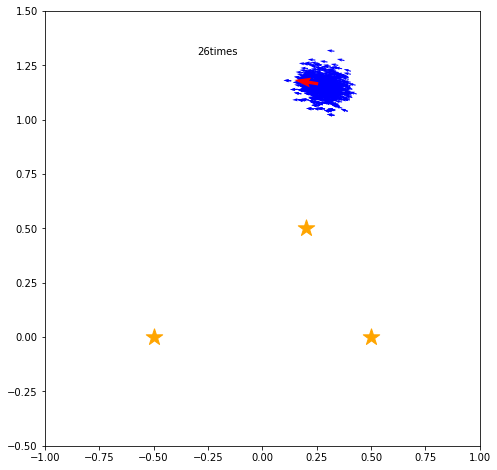

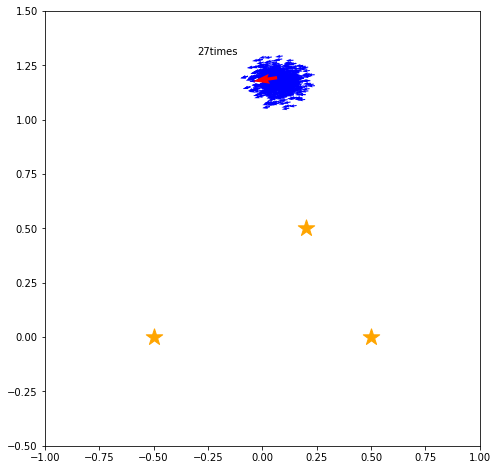

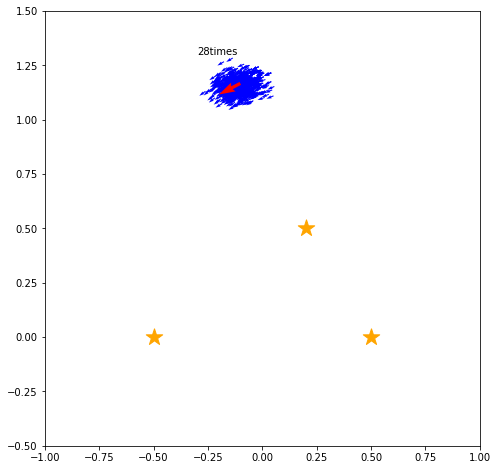

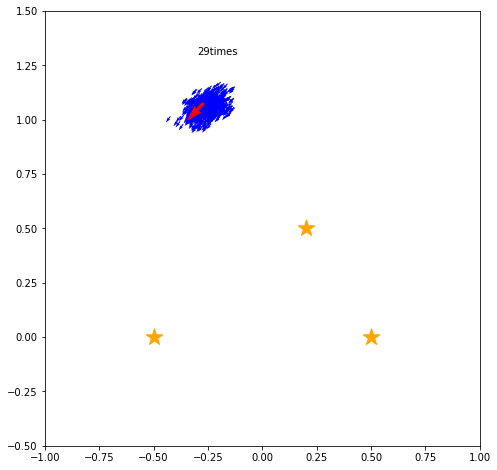

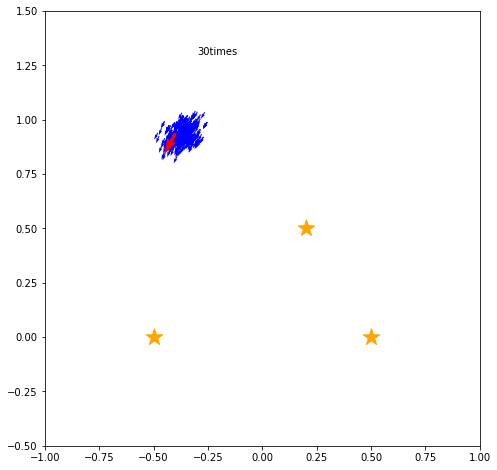

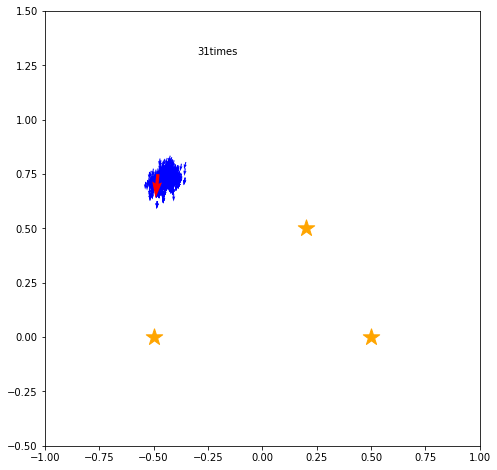

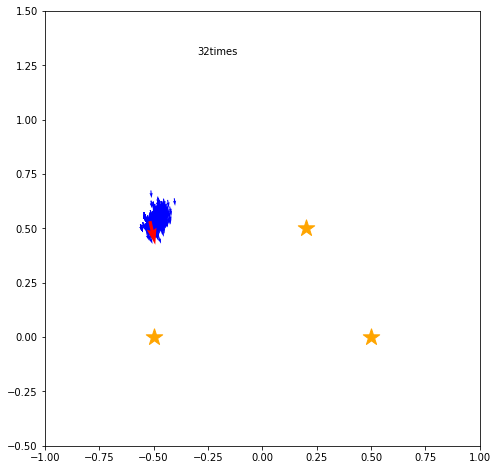

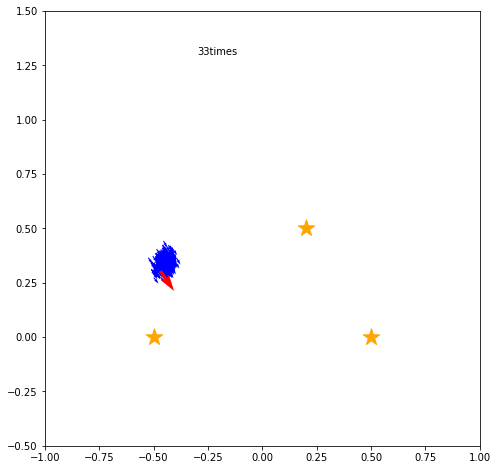

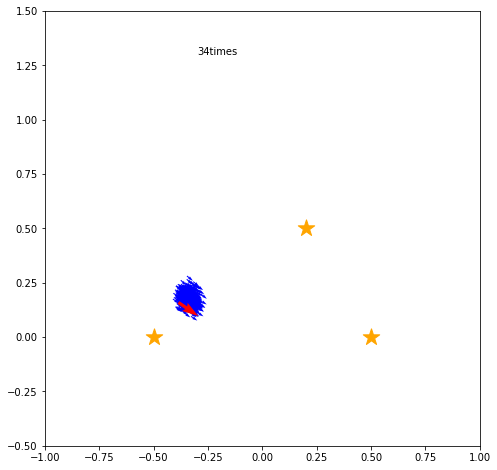

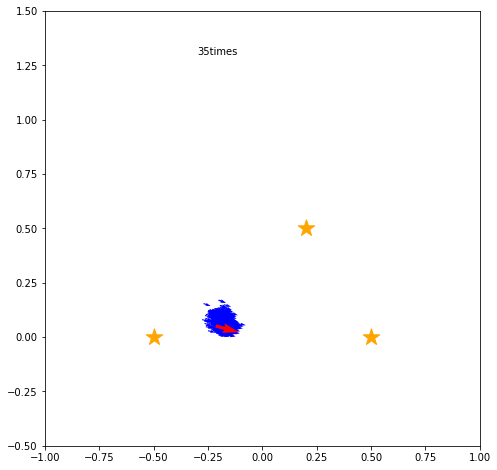

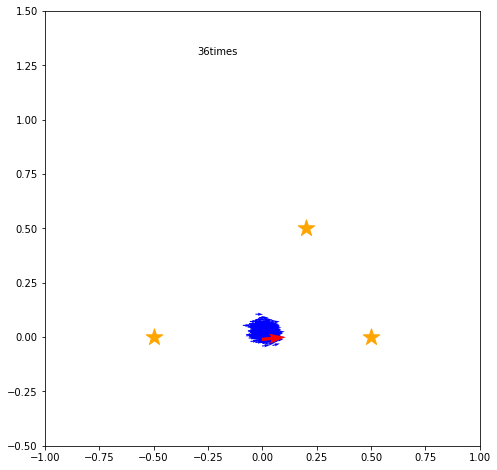

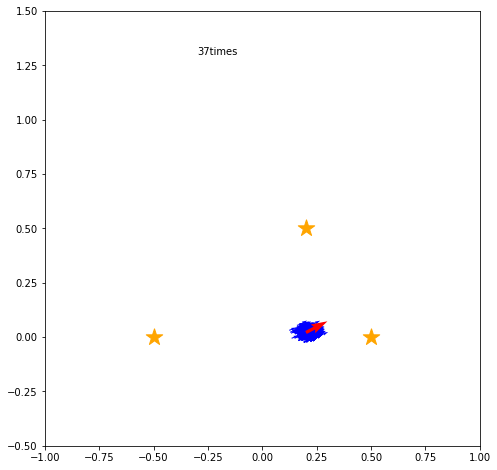

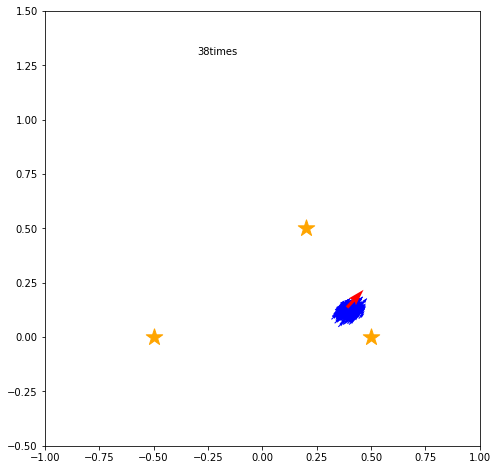

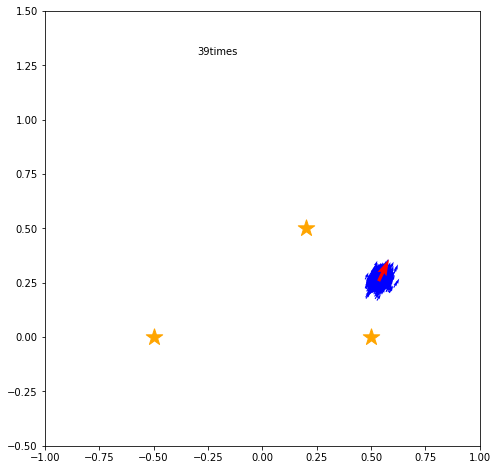

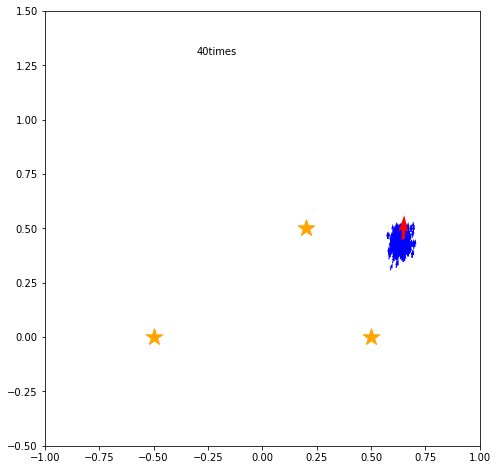

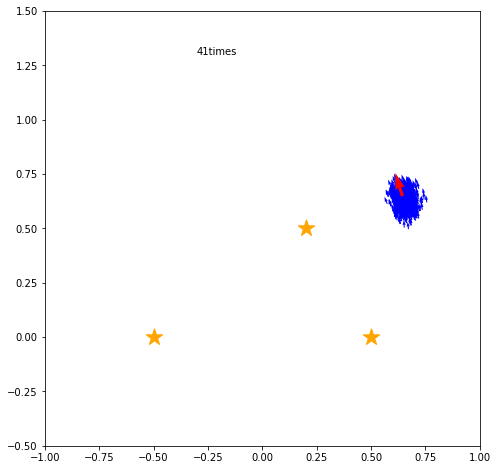

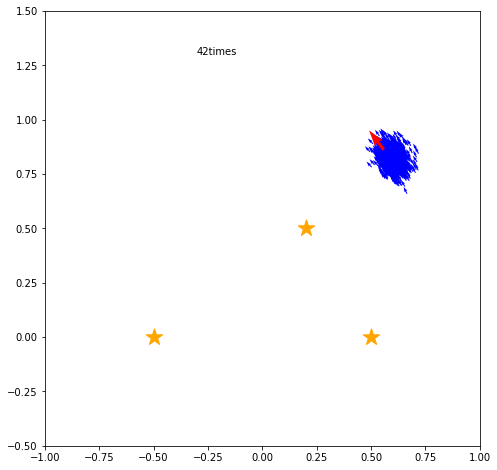

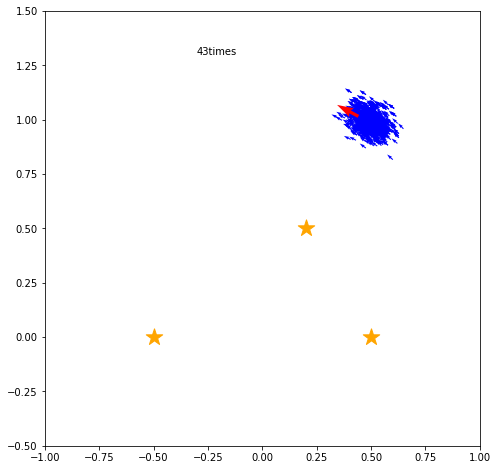

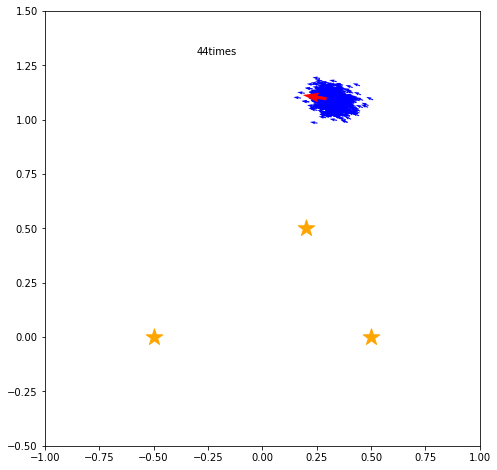

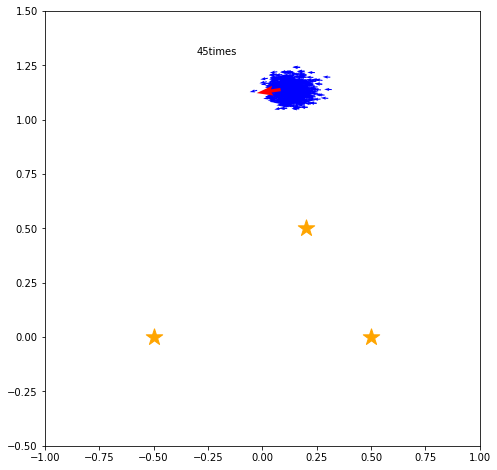

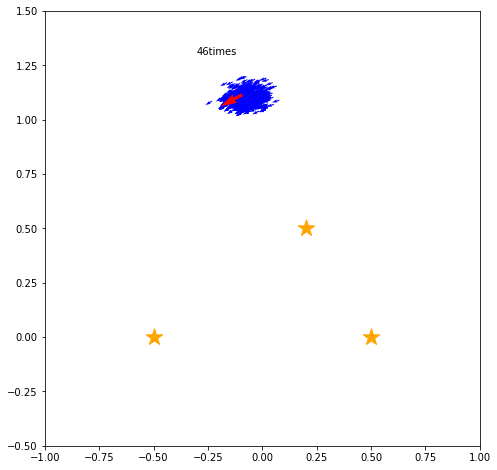

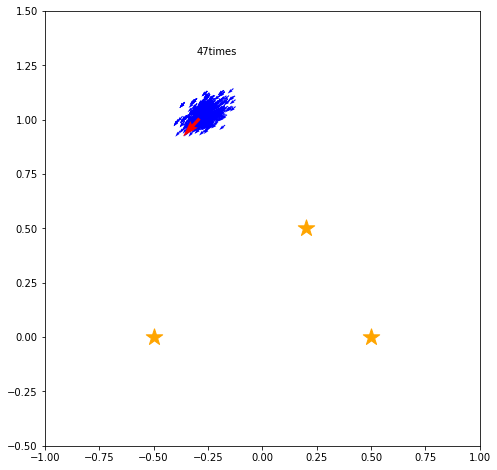

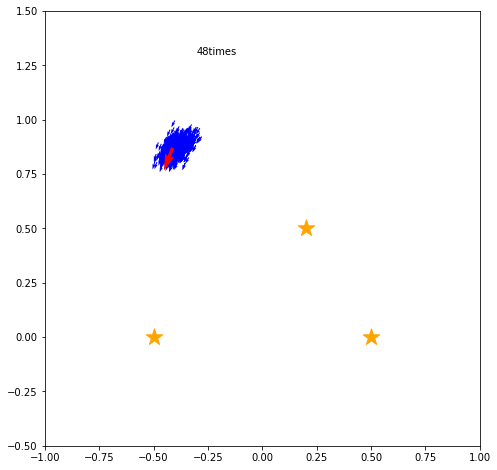

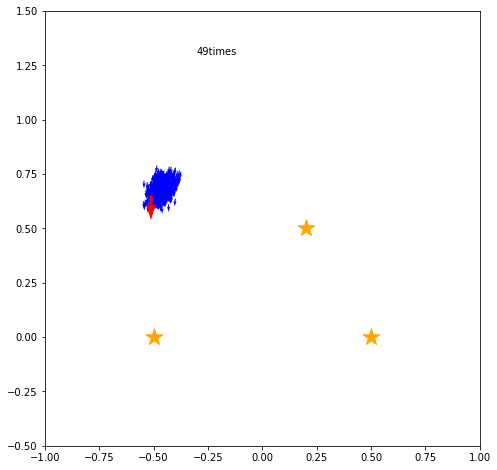

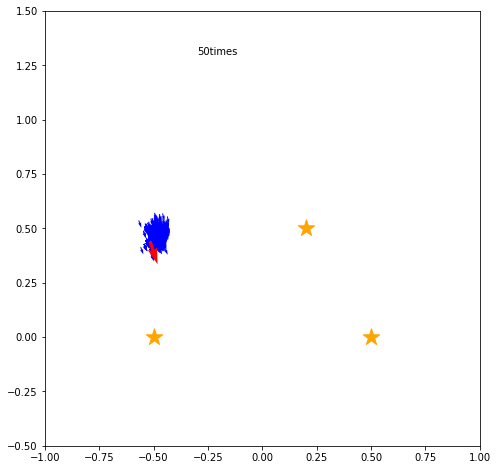

In [6]:
#ここから条件と実行

actual_x = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢 
particles = [Particle([random.uniform(-1.0,1.0),random.uniform(-0.5,0.7),(random.uniform(1,360)/180*math.pi)],1.0/1000) for i in range(1000)]
u = np.array([0.2,math.pi / 180.0 * 20]) #ロボットの移動

actual_landmarks = [np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.2,0.5])]

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(50):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurementss.append(ms)

    #motion update 
    for p in particles:
        p.pose = f(p.pose,u)
    #sensor update
    for m in ms:
        change_weights(particles, m)
    #resampling 
    particles = resampling(particles)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i],i)
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])